In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook


import pickle
import cv2
import misc
from RL_networks import Stand_alone_net

import importlib
importlib.reload(misc)

In [2]:
from __future__ import division, print_function, absolute_import

# PyTorch libraries and modules
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

from mnist import MNIST

mnist = MNIST('/home/orram/Documents/datasets/MNIST/')
images, labels = mnist.load_training()


# Training Parameters
learning_rate = 0.001
num_steps = 1000
batch_size = 64

validation_index=-5000

# Network Parameters
size=None
padding_size=(16,16)
num_input = padding_size[0]*padding_size[1] # MNIST data input (img shape: 28*28)
num_classes = None 
# dropout = 0.25 # Dropout, probability to drop a unit

## Let's see the MNIST images and the results of lowering the resolution

## Defining the network and running trayning on regular mnist

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        
        self.fc1 = nn.Linear(9*9*16,64)
        self.fc2 = nn.Linear(64,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, img):
        
        img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
        img = self.pool(self.relu(self.bn2(self.conv2(img))))
        img = self.relu(self.bn3(self.conv3(img)))        
        #print(img.shape)
        img = img.view(img.shape[0],9*9*16)
        img = self.relu(self.fc1(img))
        img = self.fc2(img)
        
        return img

### Dividing the training set to train and validate sets.

### Define dataset and dataloader for easier interaction with pytorch

In [4]:


factor = 10
train_dataset = torchvision.datasets.CIFAR10(root = '/home/orram/Documents/datasets',
                                             transform=torchvision.transforms.Compose([
                     #torchvision.transforms.Resize([factor,factor]),
                     #torchvision.transforms.Resize([32,32]), 
                     torchvision.transforms.ToTensor()]), download = True)
test_dataset = torchvision.datasets.CIFAR10(root  = '/home/orram/Documents/datasets', 
                                            train = False, transform=torchvision.transforms.Compose([
                    #torchvision.transforms.Resize([factor,factor]),
                     #torchvision.transforms.Resize([32,32]),
                    torchvision.transforms.ToTensor()]), download = True)
batch = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 1_000, shuffle = True)


Files already downloaded and verified
Files already downloaded and verified


In [7]:
epochs = 51
lr = 3e-3
net = Net().double()
optimizer = Adam(net.parameters(), lr = lr)
loss_func = nn.CrossEntropyLoss()

train_loss = []
test_loss = []
test_accur = []
for epoch in range(epochs):
    
    batch_loss = []
    for batch_idx, (data,targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = net(data.double())
        loss = loss_func(output, targets)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        
          
    train_loss.append(np.mean(batch_loss))
        
    if epoch%1 == 0:
        correct = 0
        test_batch_loss = []
        test_accuracy = []
        for batch_idx, (test_data,test_targets) in enumerate(test_dataloader):
            test_output = net(test_data)
            loss = loss_func(test_output, test_targets)
            test_batch_loss.append(loss.item())
            test_pred = test_output.data.max(1, keepdim = True)[1]
            correct = test_pred.eq(test_targets.data.view_as(test_pred)).sum()
            test_accuracy.append(100.*correct/len(test_targets))
        print('Epoch : ',epoch+1, '\t', 'loss :', loss.item(), 'accuracy :',np.mean(test_accuracy) )
        test_loss.append(np.mean(test_batch_loss))
        test_accur.append(np.mean(test_accuracy))


Epoch :  1 	 loss : 1.0804163755457943 accuracy : 63.030006
Epoch :  2 	 loss : 0.8776053292814429 accuracy : 68.03999
Epoch :  3 	 loss : 0.8777858001422071 accuracy : 69.72001


KeyboardInterrupt: 

In [ ]:
for batch_idx, (test_data,test_targets) in enumerate(test_dataloader):
    test_output = net(test_data)
    loss = loss_func(test_output, test_targets)
    test_batch_loss.append(loss.item())
    test_pred = test_output.data.max(1, keepdim = True)[1]
    correct += pred.eq(test_targets.data.view_as(test_pred)).sum()
    test_accuracy = 100.*correct/len(test_targets)
    print('Epoch : ',epoch+1, '\t', 'loss :', loss.item(), 'accuracy :',test_accuracy )

In [ ]:
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# empty list to store accuracies 
train_accuracies = []
val_accuracies = []
batch_size=64
train_set_stop=-1
n_epochs = 100
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(2.2469, dtype=torch.float64, grad_fn=<NllLossBackward>) accuracy : tensor(16.2200)
Epoch :  1 	 loss : tensor(2.1883, dtype=torch.float64, grad_fn=<NllLossBackward>) accuracy : tensor(29.9800)


### Now to find the effects of lowering the resolution

In [8]:
def create_dataloader(factor):
    train_dataset = mnist_dataset(train_x, train_y, 
                transform=torchvision.transforms.Compose(
                    [torchvision.transforms.Resize([factor,factor]),
                     torchvision.transforms.Resize([28,28])]))
    test_dataset = mnist_dataset(val_x, val_y,
                transform=torchvision.transforms.Compose(
                    [torchvision.transforms.Resize([factor,factor]),
                     torchvision.transforms.Resize([28,28])]))
    batch = 64
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch, shuffle = True)
    val_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 5_000, shuffle = True)
    
    return train_dataloader, val_dataloader



In [9]:
def train( factor, train_dataloader, test_dataloader,epochs = 1,):
    epochs = epochs
    lr = 3e-3
    net = Net().double()
    optimizer = Adam(net.parameters(), lr = lr)
    loss_func = nn.CrossEntropyLoss()

    train_loss = []
    test_loss = []
    test_accur = []
    for epoch in range(epochs):

        batch_loss = []
        for batch_idx, (data,targets) in enumerate(train_dataloader):
            optimizer.zero_grad()
            output = net(data.double())
            loss = loss_func(output, targets)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())


        train_loss.append(np.mean(batch_loss))

        if epoch%5 == 0:
            correct = 0
            test_batch_loss = []
            for batch_idx, (data,targets) in enumerate(val_dataloader):
                output = net(data)
                loss = loss_func(output, targets)
                test_batch_loss.append(loss.item())
                pred = output.data.max(1, keepdim = True)[1]
                correct += pred.eq(targets.data.view_as(pred)).sum()
                test_accuracy = 100.*correct/len(targets)
                print('Epoch : ',epoch+1, '\t', 
                      'train loss :', np.round(train_loss[-1], decimals = 3),'\t', 
                      'test loss :', np.round(loss.item(), decimals = 3),'\t', 
                      'accuracy :',np.round(float(test_accuracy), decimals = 3) )
            test_loss.append(np.mean(test_batch_loss))
            test_accur.append(test_accuracy)
    plt.figure()
    plt.imshow(data[0].squeeze(0))
    plt.title('For factor = {} - \n train loss : {}           test loss : {} \n test accuracy : {}'.format( 
        factor,
        np.round(train_loss[-1], decimals = 3), 
        np.round(loss.item(), decimals = 3),
        np.round(float(test_accuracy), decimals = 3)))
    
            
    return train_loss, test_loss, test_accur

Epoch :  1 	 train loss : 1.876 	 test loss : 1.8 	 accuracy : 32.42
Epoch :  6 	 train loss : 1.821 	 test loss : 1.776 	 accuracy : 33.78
Epoch :  11 	 train loss : 1.813 	 test loss : 1.779 	 accuracy : 33.38
Epoch :  16 	 train loss : 1.812 	 test loss : 1.772 	 accuracy : 33.74
Epoch :  21 	 train loss : 1.809 	 test loss : 1.774 	 accuracy : 33.76


<IPython.core.display.Javascript object>


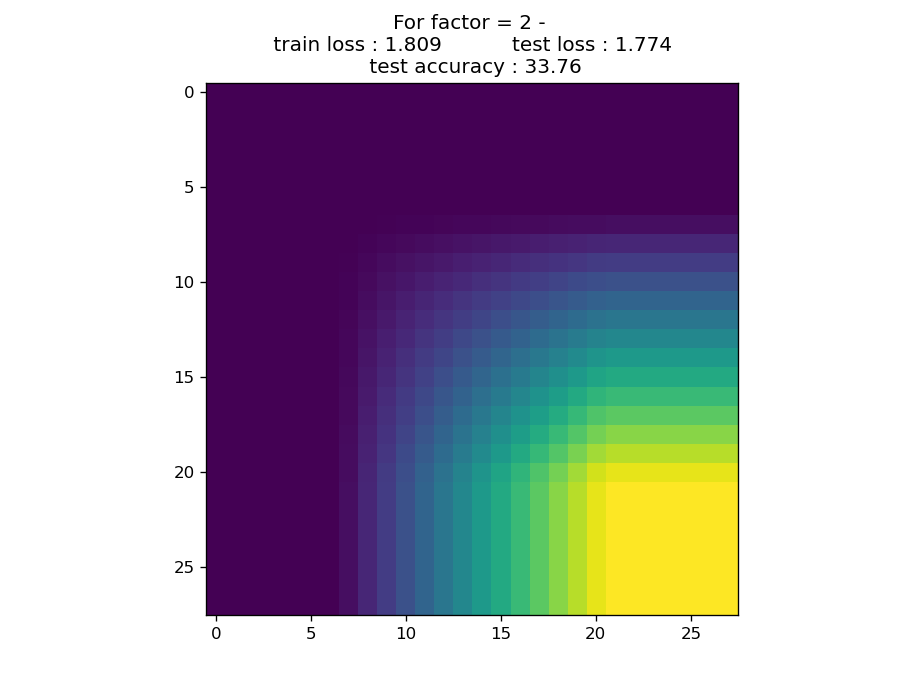

In [12]:
TRAIN_loss = []
TEST_loss = []
TEST_accur = []
factor_list = np.flip(1)
for factor in [2]:
    train_dataloader, val_dataloader = create_dataloader(factor)
    train_loss, test_loss, test_accur = train(factor,train_dataloader, val_dataloader, epochs = 21)
    TRAIN_loss.append(train_loss[-1])
    TEST_loss.append(test_loss[-1])
    TEST_accur.append(test_accur[-1])



<IPython.core.display.Javascript object>


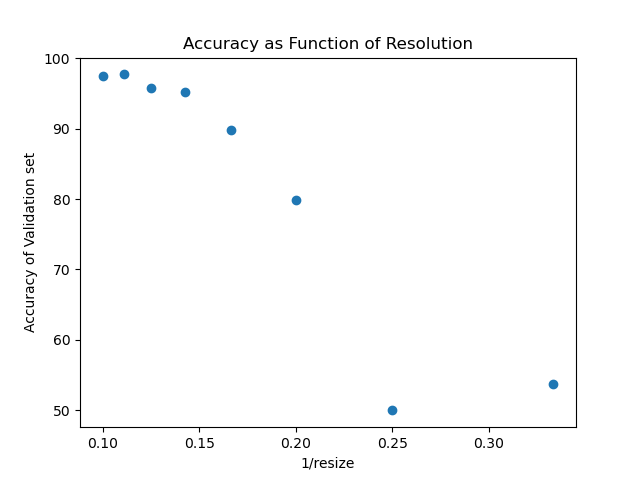

Text(0.5, 1.0, 'Accuracy as Function of Resolution')

In [86]:
plt.figure()  
plt.plot(1/factor_list,TEST_accur,'o')
plt.xlabel('1/resize')
plt.ylabel('Accuracy of Validation set')
plt.title('Accuracy as Function of Resolution')

torch.Size([5000, 1, 28, 28]) torch.Size([1, 28, 28])


<IPython.core.display.Javascript object>


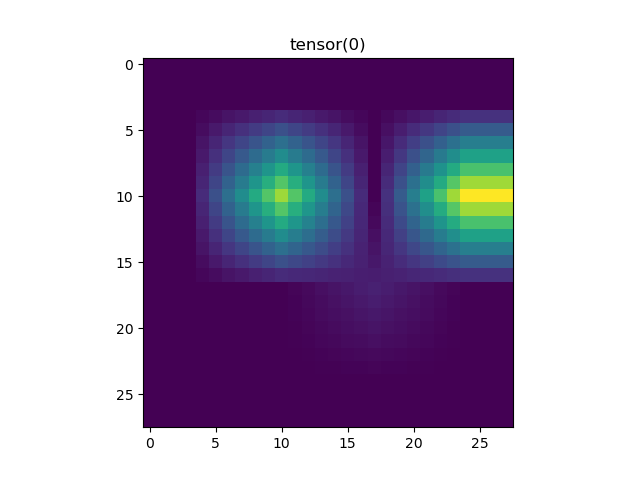

Text(0.5, 1.0, 'tensor(0)')

In [59]:
print(data.shape, data[0].shape)
plt.figure()
plt.imshow(test_dataset[402][0].squeeze(0))
plt.title(test_dataset.labels[402])